# CLIMATOLGY

In this notebook the climatology is computed for the list of basins that are modeled. The climatology is than used for the prediction of 10 and 20 days of advance.

In [2]:
import sys
sys.path.insert(0, "..")

from climatology_ensemble import daily_climatology_p_et_ensemble

from create_daily_csv import readsnow_in_shp_db, xarray2df, check_data_gap, readnetcdf_in_shp_db, get_discharge_from_DB
from create_daily_csv import spatial_stats_daily_input
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plot
import xarray as xr
import datetime
import psycopg2
import matplotlib.pyplot as plt

from joblib import load
from base_f import create_it_matrix
from db_insert import insert

t_unit=10

In [3]:
LIST=['ADO_DSC_CH03_0075',
     'ADO_DSC_AT31_0254',
     'ADO_DSC_ITC1_0072',
     'ADO_DSC_ITC1_0020',
     'ADO_DSC_CH07_0147',
     'ADO_DSC_AT31_0206',
     'ADO_DSC_ITH1_0012',
     'ADO_DSC_AT12_0280',
     'ADO_DSC_CH07_0100',
     'ADO_DSC_CH05_0201',
     'ADO_DSC_SI03_0148',
     'ADO_DSC_ITC1_0037',
     'ADO_DSC_FRK2_0042',
     'ADO_DSC_CH04_0011',
     'ADO_DSC_ITH2_0035',
     'ADO_DSC_SI03_0033',
     'ADO_DSC_FRK2_0041',
     'ADO_DSC_ITH5_0006',
     'ADO_DSC_CH07_0006']

era5_fileName_t=  'Z:\ADO\ZAMG\downscaled_archive\\2m_temperature-19790101_20201231-eusalp-era5_qm.nc'
era5_fileName_e = 'Z:\ADO\ZAMG\downscaled_archive\\potential_evapotranspiration-19790101_20201231-eusalp-qm_era5.nc'
era5_fileName_p = 'Z:\ADO\ZAMG\downscaled_archive\\total_precipitation-19790101_20201231-eusalp-qm_era5.nc'
era5_foldName_s = 'Z:\ADO\ZAMG\SNOWGRID\\'
# mask file needed to exclude pixels on the glaciers.
mask_file=r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\era5\SNOWGRID\\snowgrid_masks.nc'

path = r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\conda\Runoff_prediction\model_predict\climatology\\'

import sys, importlib
importlib.reload(sys.modules['create_daily_csv'])

In [4]:
for STAT_CODE in LIST:
    
    t2m = readnetcdf_in_shp_db(era5_fileName_t,STAT_CODE ,plot=False,res=5500)['t2m']
    t2m_h = t2m    
    t2m_h = xarray2df(t2m_h.resample(time='1d').sum(skipna=False), 'T','t2m')
    ### ERA5 total precipitation

    #CLIP TO THE SHAPEFILE
    tp = readnetcdf_in_shp_db(era5_fileName_p,STAT_CODE ,plot=False,res=5500)['tp']
    tp_h = tp
    tp_h = xarray2df(tp_h.resample(time='1d').sum(skipna=False), 'P','tp')


    ### ERA5 evapotranspiration

    #CLIP TO THE SHAPEFILE
    pet = readnetcdf_in_shp_db(era5_fileName_e,STAT_CODE ,plot=False,res=5500)['pet']
    pet_h=pet
    pet_h = xarray2df(pet_h.resample(time='1d').sum(skipna=False), 'E','pet')

    ### ERA5 SNOW VARIABLES

    #CLIP TO THE SHAPEFILE
    s = readsnow_in_shp_db(era5_foldName_s,mask_file,STAT_CODE ,plot=False,res=5500)['swe_tot']
    s_h = s
    s_h = xarray2df(s_h.resample(time='1d').sum(skipna=False), 'S','swe_tot')

    #CONCATENATE THE VARIABLES
    daily_input_h =pd.concat([t2m_h, s_h, tp_h, pet_h], axis=1, join='inner')
    daily_input_stat_h = spatial_stats_daily_input(daily_input_h)


    daily_input_stat_h['Q']=0
    daily_clim = daily_climatology_p_et_ensemble(daily_input_stat_h,t_unit)
    
    daily_clim.drop(columns='Q',inplace=True)
    daily_clim.index.name='day_of_year'
    
    daily_clim.to_csv(path + STAT_CODE + '.csv', header=True)

<AxesSubplot:xlabel='day_of_year'>

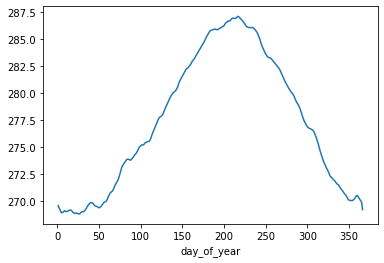

In [8]:
daily_clim['T'].plot.line()

In [1]:
daily_clim['S'].plot.line()

NameError: name 'daily_clim' is not defined

<AxesSubplot:xlabel='day_of_year'>

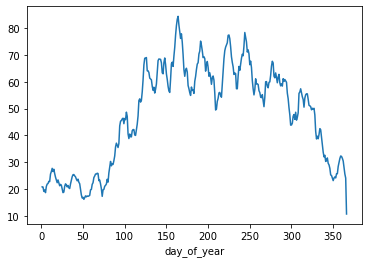

In [33]:
daily_clim['P'].plot.line()